In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Sketch-experiments/function_approximation/real-world

%run -i framework.py
%run -i real.py
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

## Read Data  

In [ ]:
df = pd.read_csv('./youtube.csv')
df.head()

,video_id,channel_title,view_count,published_at,likes,dislikes,datetime,elapsed
0,--0bCF-iK2E,Bundesliga,1048888,2021-07-01 10:00:00,19515,226,2021-07-01 10:00:00,165
1,--14w5SOEUs,MigosVEVO,15352638,2021-06-10 16:00:00,359277,7479,2021-06-10 16:00:00,186
2,--40TEbZ9Is,Television Academy,925281,2021-09-20 01:03:32,11212,401,2021-09-20 01:03:32,84
3,--4tfbSyYDE,JO1,2641597,2021-03-03 10:00:17,39131,441,2021-03-03 10:00:17,285
4,--DKkzWVh-E,Practical Engineering,715724,2021-12-07 13:00:00,32887,367,2021-12-07 13:00:00,6


## Statistics to measure the performance of each upload

- View count $v$

- log of View count: $\log(v+1)$

- Like ratio: $l(v)/(l(v)+d(v))$

- Variation of like ratio: $(l(v)+\alpha)/(l(v)+d(v) +\beta)$

The last statistics is motivated by Bayesian estimation. We test the value $(\alpha,\beta) = (0.01v,0.1v)$ and $(0.05v,0.1v)$.

In [ ]:
m = ['view_day', 'log_view', 'like_ratio', 'VPI', 'conservative', 'balanced']

In [ ]:
df = df.assign(view_day = (np.round( df['view_count'] / df['elapsed'], decimals=4)))
df = df.assign(log_view = (np.round( np.log(df['view_count'] + 1), decimals=4)))
df = df.assign(like_ratio = (np.round(df['likes']/(df['likes']+df['dislikes']),decimals=4)))
df = df.assign(VPI = (np.round(df['likes']/(df['likes']+df['dislikes']) * (df['view_count'] / df['elapsed']) / 100
                                        ,decimals=4)))
df = df.assign(conservative = (np.round((df['likes'] + 0.01*df['view_count'])/(df['likes']+df['dislikes']+ 0.1*df['view_count'])
                                        ,decimals=4)))
df = df.assign(balanced = (np.round((df['likes'] + 0.05*df['view_count'])/(df['likes']+df['dislikes']+ 0.1*df['view_count'])
                                        ,decimals=4)))
df.head()
df.to_csv('youtube_score.csv', index=False)
## df = pd.read_csv('./youtube_score.csv')

In [ ]:
users = np.array(df['channel_title'].dropna(how='any').unique())
num_users = users.size
data = np.array([np.array(df[df['channel_title']==user]['view_count']) for user in users],dtype=object)
# discard some candidates
data_sizes = np.array([data[i].size for i in range(num_users)])
candidates = np.array([i for i in range(num_users) if data_sizes[i] >= 50])

In [ ]:
import pickle5 as pickle
with open('candidates.pickle', 'wb') as f:
    pickle.dump(candidates, f)

In [ ]:
df2 = df[df['channel_title'].isin(users[candidates])]

In [ ]:
df2.to_csv('youtube_ECDF.csv', index=False)

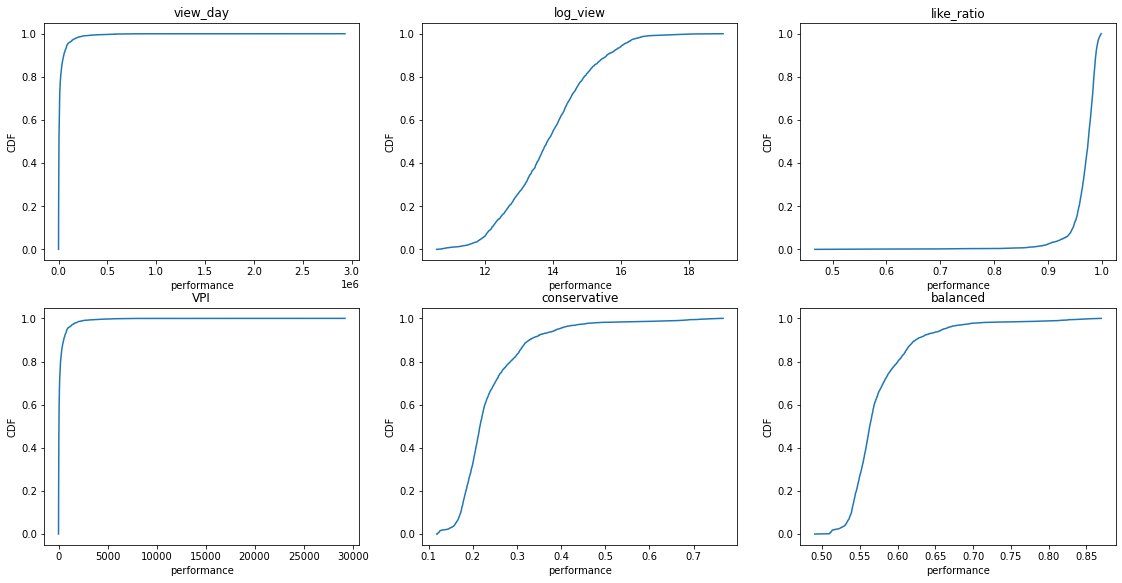

In [ ]:
from itertools import product
fig, axes = plt.subplots(2, 3, figsize = (6.4*3, 4.8*2))
axes[0,0].plot(ECDF(df2['view_day']).x, ECDF(df2['view_count']).y)
axes[0,1].plot(ECDF(df2['log_view']).x, ECDF(df2['log_view']).y)
axes[0,2].plot(ECDF(df2['like_ratio']).x, ECDF(df2['like_ratio']).y)
axes[1,0].plot(ECDF(df2['VPI']).x, ECDF(df2['VPI']).y)
axes[1,1].plot(ECDF(df2['conservative']).x, ECDF(df2['conservative']).y)
axes[1,2].plot(ECDF(df2['balanced']).x, ECDF(df2['balanced']).y)
u = 0
for i, j in product(range(2), range(3)):
    axes[i, j].set_title(m[u])
    axes[i, j].set_ylabel("CDF")
    axes[i, j].set_xlabel("performance")
    u += 1

## Comparison results  
We compare the results of our method with $\epsilon = 0.01$ and that of test scores for all six measures.

In [ ]:
def create_output_comp():
    column_labels_raw = ['obj','k','measure', 'test_number', 'ratio_TS', 'ratio_EB']
    df_raw = pd.DataFrame(columns=column_labels_raw)
    df_raw.to_csv('res_score_full.csv', index=False)

In [ ]:
def run_comparison(n, k, n_sample, samples_p, samples_q, obj, n_sets, set_items):
    df = pd.read_csv('./res_score_full.csv')

    value_P = get_value(n, n_sample, samples_p, obj, set_items)
    value_Q = get_value(n, n_sample, samples_q, obj, set_items)
    value_S = get_valueS(n, k, n_sample, samples_p, obj, set_items)

    for j in range(n_sets):
        df = df.append({'obj': obj, 'k':k, 'measure': ms,
                        'test_number': j+1, 'ratio_EB': value_Q[j]/value_P[j],
                        'ratio_TS': value_S[j]/value_P[j]}, ignore_index = True)
    df.to_csv('res_score_full.csv', index=False)

In [ ]:
create_output_comp()

In [ ]:
n = len(candidates)
for ms in m:
    data = np.array([np.array(df[df['channel_title']==user][ms]) for user in users],dtype=object)
    samples_p = Real_sample(data, candidates, n_sample)
    samples_q = Discretized_real_sample(data, candidates, 0.01, n_sample)
    for k in kvals:
        set_items = get_sets(n, k, n_sets)
        for obj in objs:
            run_comparison(n, k, n_sample, samples_p, samples_q, obj, n_sets, set_items)

In [ ]:
def box_plot(k):
    fig, axes = plt.subplots(2, 3, figsize = (6.4*3, 4.8*2))
    df = pd.read_csv('./res_score_full.csv')
    flierprops = dict(marker='o', markeredgecolor='lightgrey')
    u = 0
    for i, j in product(range(2), range(3)):
        current = df[(df['k'] == k)& (df['measure'] == m[u])]
        current.boxplot(ax = axes[i, j], column = 'ratio_EB', by = 'obj', flierprops = flierprops)
        axes[i, j].set_xlabel("objectives")
        axes[i, j].set_ylabel("v(S)/u(S)")
        axes[i, j].set_title(m[u])
        axes[i, j].set_ylim((0.5, 1.5))
        u += 1
    fig.suptitle('')

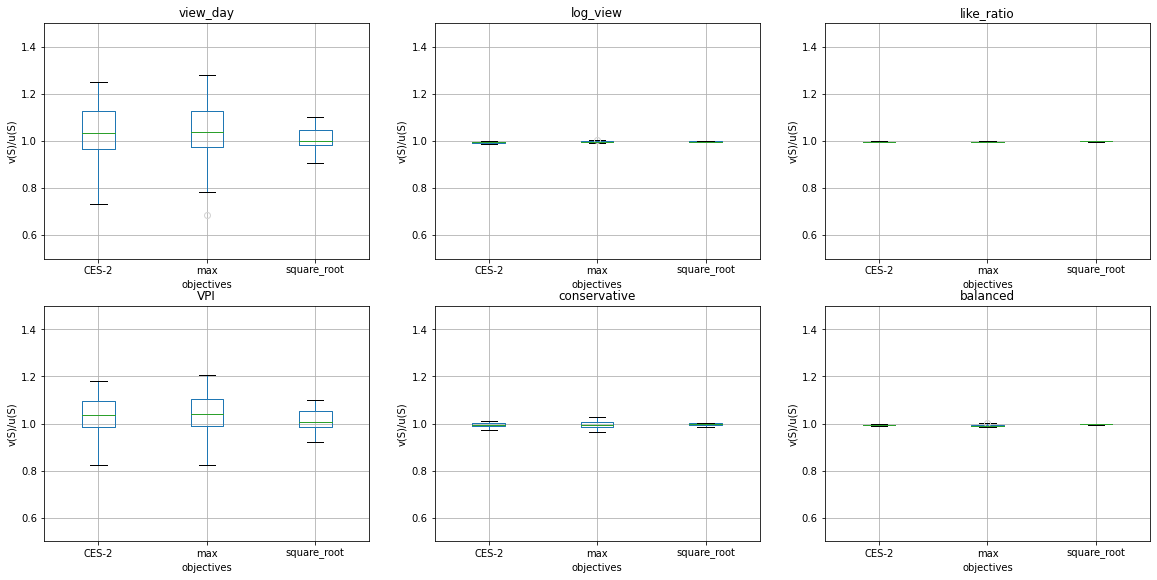

In [ ]:
box_plot(5)